##  Montgomery County (MC) 311 Requests Analysis
1. Analyze the # of 311 requests for each type before and after lockdown (March 2020)
2. Exploratay analysis on FEMS requests

### Some findings:
1. There are more than 3000 types of service, while some of them have been only reported once
2. 831 types of service requests changed significantly after lock down (p-val <0.05)
3. t-test results can be found at the result directory (../result/MC_service_type_ttest.csv) 

In [1]:
import numpy as np
import pandas as pd
import os
import re
import glob
import csv
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
warnings.filterwarnings("ignore")
MC_311_2019 = '/Users/julia/Box/Data_311/DMV_311/DMV_nonEM/Montgomery County/311_Montgomery County_MD_2019.csv'
MC_311_2020 = '/Users/julia/Box/Data_311/DMV_311/DMV_nonEM/Montgomery County/311_Montgomery County_MD_2020.csv'

### All 311 Requests in MC during 2019 to 2020

1. MC 2019

In [2]:
MC_311_2019_df = pd.read_csv(MC_311_2019,index_col=0)
MC_311_2019_df.head()

,SR ID,Opened,Closed,Status,Department,Area,Sub-Area,Attached Solution (Topic),Attached Solution SLA Days,City,...,Congressional District,Congressional Member,Council District,Council Member Name,Changed Date,# of Days Open,Within SLA Windows,SLA Yes,SLA No,opened_date
0,1377072702,01/15/2019 09:54:44 AM,01/18/2019 12:48:24 PM,Closed,DOT,Highway Services,Snow Removal,Report Unplowed or Missed Street,1.0,SILVER SPRING,...,8.0,"CHRISTOPHER VAN HOLLEN,JR -Dem",4.0,Nancy Navarro,01/18/2019 05:48:27 PM,3,No,0,1,2019-01-15 09:54:44
1,1377076280,01/15/2019 11:30:18 AM,01/18/2019 11:43:34 AM,Closed,DEP,Environmental Code Enforcement,Illegal Dumping,Illegal Dumping,20.0,DAMASCUS,...,8.0,"CHRISTOPHER VAN HOLLEN,JR -Dem",2.0,Craig Rice,01/18/2019 04:43:34 PM,3,Yes,1,0,2019-01-15 11:30:18
2,1377080766,01/15/2019 11:11:58 AM,01/18/2019 07:13:02 AM,Closed,DEP,Solid Waste,Scrap Metal Request,Scrap Metal Pick-Up Request,5.0,SILVER SPRING,...,3.0,JOHN P. SARBANES -Dem,5.0,Tom Hucker,01/18/2019 12:13:04 PM,3,Yes,1,0,2019-01-15 11:11:58
3,1377086396,01/15/2019 11:12:52 AM,01/18/2019 10:50:51 AM,Closed,HHS,Children Youth and Families,OESS,Income Support Application Status: Food Stamps...,2.0,SILVER SPRING,...,3.0,JOHN P. SARBANES -Dem,5.0,Tom Hucker,01/18/2019 03:50:53 PM,3,No,0,1,2019-01-15 11:12:52
4,1377086517,01/15/2019 11:30:57 AM,01/18/2019 07:41:32 AM,Closed,DEP,Solid Waste,Scrap Metal Request,Scrap Metal Pick-Up Request,5.0,POTOMAC,...,6.0,JOHN K. DELANEY -Dem,1.0,Roger Berliner,01/18/2019 12:41:47 PM,3,Yes,1,0,2019-01-15 11:30:57


In [3]:
MC_311_2019_df.columns

Index(['SR ID', 'Opened', 'Closed', 'Status', 'Department', 'Area', 'Sub-Area',
       'Attached Solution (Topic)', 'Attached Solution SLA Days', 'City',
       'State', 'Zip Code', 'Source', 'Election District',
       'Maryland State District', 'Congressional District',
       'Congressional Member', 'Council District', 'Council Member Name',
       'Changed Date', '# of Days Open', 'Within SLA Windows', 'SLA Yes',
       'SLA No', 'opened_date'],
      dtype='object')

In [4]:
MC_311_2019_df['opened_date'] = pd.to_datetime(MC_311_2019_df['Opened'], format='%m/%d/%Y %I:%M:%S %p')
MC_311_2019_df = MC_311_2019_df.loc[ MC_311_2019_df['opened_date'].dt.year == 2019]
MC_311_2019_df.drop_duplicates(subset=['SR ID'], inplace = True)
min_date = min(MC_311_2019_df['opened_date'])
max_date = max(MC_311_2019_df['opened_date'])
print("#311 reports between " + str(min_date) + " and " + str(max_date) + ": " + str(MC_311_2019_df.shape[0]))

#311 reports between 2019-01-01 00:22:32 and 2019-12-31 22:51:04: 555509


2. MC 2020

In [5]:
MC_311_2020_df = pd.read_csv(MC_311_2020,index_col=0)
MC_311_2020_df.head()

,SR ID,Opened,Closed,Status,Department,Area,Sub-Area,Attached Solution (Topic),Attached Solution SLA Days,City,...,Congressional District,Congressional Member,Council District,Council Member Name,Changed Date,# of Days Open,Within SLA Windows,SLA Yes,SLA No,opened_date
0,1421822412,06/01/2020 09:04:50 AM,07/27/2020 03:21:15 PM,Closed,DHCA,Code Enforcement,NaN,Tall Grass on Private Property Where the Prope...,25.0,POTOMAC,...,6.0,David Throne -Dem,1.0,Andrew Friedson,07/27/2020 07:21:15 PM,40,No,0,1,2020-06-01 09:04:50
1,1407530213,01/03/2020 12:21:48 PM,01/15/2020 09:52:20 AM,Closed,DEP,Solid Waste,Cart Repair,Cart Repair,10.0,CLARKSBURG,...,6.0,David Throne -Dem,2.0,Craig Rice,01/15/2020 02:52:20 PM,8,Yes,1,0,2020-01-03 12:21:48
2,1407534460,01/03/2020 05:24:46 PM,01/15/2020 09:42:52 AM,Closed,DEP,Solid Waste,Bin Pick-Up,22 Gallon Bin Pick-up,10.0,GAITHERSBURG,...,8.0,Jamie Raskin -Dem,4.0,Nancy Navarro,01/15/2020 02:42:52 PM,8,Yes,1,0,2020-01-03 17:24:46
3,1407797304,01/07/2020 01:11:13 PM,01/15/2020 01:51:51 PM,Closed,DEP,Solid Waste,Bin Pick-Up,22 Gallon Bin Pick-up,10.0,BURTONSVILLE,...,3.0,JOHN P. SARBANES -Dem,5.0,Tom Hucker,01/15/2020 06:51:51 PM,6,Yes,1,0,2020-01-07 13:11:13
4,1407683077,01/06/2020 09:25:32 AM,01/15/2020 02:30:33 PM,Closed,HHS,Children Youth and Families,OESS,Contact Income Supports Case Manager Germantown,4.0,GERMANTOWN,...,6.0,David Throne -Dem,2.0,Craig Rice,01/15/2020 07:32:42 PM,7,No,0,1,2020-01-06 09:25:32


In [6]:
MC_311_2020_df.columns

Index(['SR ID', 'Opened', 'Closed', 'Status', 'Department', 'Area', 'Sub-Area',
       'Attached Solution (Topic)', 'Attached Solution SLA Days', 'City',
       'State', 'Zip Code', 'Source', 'Election District',
       'Maryland State District', 'Congressional District',
       'Congressional Member', 'Council District', 'Council Member Name',
       'Changed Date', '# of Days Open', 'Within SLA Windows', 'SLA Yes',
       'SLA No', 'opened_date'],
      dtype='object')

In [7]:
MC_311_2020_df['opened_date'] = pd.to_datetime(MC_311_2020_df['Opened'], format='%m/%d/%Y %I:%M:%S %p')
MC_311_2020_df = MC_311_2020_df.loc[ MC_311_2020_df['opened_date'].dt.year == 2020]
MC_311_2020_df.drop_duplicates(subset=['SR ID'], inplace = True)
min_date = min(MC_311_2020_df['opened_date'])
max_date = max(MC_311_2020_df['opened_date'])
print("#311 reports between " + str(min_date) + " and " + str(max_date) + ": " + str(MC_311_2020_df.shape[0]))

#311 reports between 2020-01-01 02:08:54 and 2020-12-31 23:19:24: 576486


### Service types in MC
Attached Solution (Topic) - service type in Montgomery County 

1. 2019

In [8]:
service_desc_2019 = MC_311_2019_df['Attached Solution (Topic)'].unique().tolist()
print( len(service_desc_2019))
service_desc_2019[0:10]

3113


['Report Unplowed or Missed Street',
 'Illegal Dumping',
 'Scrap Metal Pick-Up Request',
 'Income Support Application Status: Food Stamps TCA Medicaid TDAP Silver Spring Office',
 'Income Support Application Status: Food Stamps TCA Medicaid TDAP Rockville Office',
 '22 Gallon Bin Pick-up ((Bottles/Cans/Jars)',
 'Report an Un-shoveled Sidewalk',
 'Cart Repair (Paper Recycling)',
 'Termination of case: food stamps, TCA, Medicaid, TDAP  - Rockville',
 'Property Tax Credit for Elderly Individuals and for Military Retirees']

In [21]:
service_count_2019 = MC_311_2019_df.groupby('Attached Solution (Topic)').size().reset_index().sort_values(by=[0],ignore_index=True)
service_count_2019.rename(columns = {0:'#reports'},inplace = True)
service_count_2019

,Attached Solution (Topic),#reports
0,Official County Car Use,1
1,Parking Restrictions during WMATA Safetrack,1
2,Participating Agency Employee - Form 1095-C,1
3,Participating Agency Employee - Open Enrollmen...,1
4,"Financial Donations to Montgomery County, MD",1
...,...,...
3107,Schedule Residential Inspections,16910
3108,Ride On Real Time Arrival Information,24217
3109,22 Gallon Bin Delivery (Bottles/Cans/Jars),25229
3110,Scrap Metal Pick-Up Request,26927


394 types were only reported once 

In [24]:
service_count_2019.loc[service_count_2019['#reports'] <=1]

,Attached Solution (Topic),#reports
0,Official County Car Use,1
1,Parking Restrictions during WMATA Safetrack,1
2,Participating Agency Employee - Form 1095-C,1
3,Participating Agency Employee - Open Enrollmen...,1
4,"Financial Donations to Montgomery County, MD",1
...,...,...
389,Salary Continuation Benefit for Worker's Compe...,1
390,Sample Ballot,1
391,Alcohol Violations,1
392,Alcohol Use in School or Government Facility,1


1650 types were reported more than 10 times

In [49]:
service_count_2019.loc[service_count_2019['#reports'] >=10]

,Attached Solution (Topic),#reports
1462,Using a Current Copy of State or County Licens...,10
1463,Obtain an Application to Purchase an MPDU,10
1464,Requests for Disability Related Assistance for...,10
1465,Housing Emergency Rockville,10
1466,Maryland's Commitment to Veterans,10
...,...,...
3107,Schedule Residential Inspections,16910
3108,Ride On Real Time Arrival Information,24217
3109,22 Gallon Bin Delivery (Bottles/Cans/Jars),25229
3110,Scrap Metal Pick-Up Request,26927


In [28]:
num_report_dist = service_count_2019.groupby('#reports')['Attached Solution (Topic)'].size().reset_index().rename(columns = {'Attached Solution (Topic)':'#service types'})
num_report_dist

,#reports,#service types
0,1,394
1,2,252
2,3,210
3,4,146
4,5,126
...,...,...
456,16910,1
457,24217,1
458,25229,1
459,26927,1


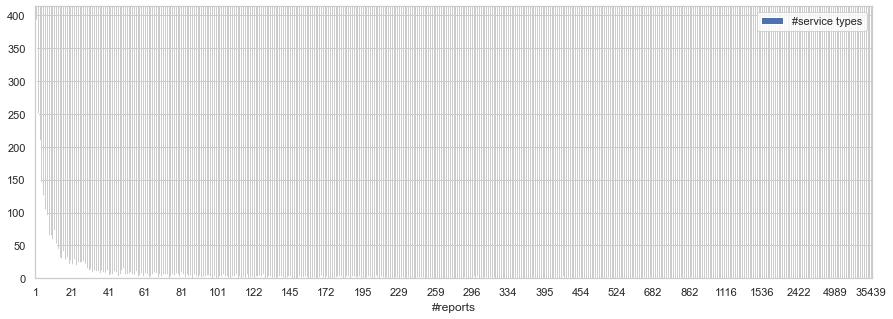

In [44]:
ax = num_report_dist.plot.bar(x='#reports', y='#service types', rot=0,figsize=(15,5))
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 20) != 0:
        t.set_visible(False)
plt.show()

2. 2020

In [10]:
service_desc_2020 = MC_311_2020_df['Attached Solution (Topic)'].unique().tolist()
print(len(service_desc_2020))
service_desc_2020[0:10]

3016


['Tall Grass on Private Property Where the Property is Occupied',
 'Cart Repair',
 '22 Gallon Bin Pick-up',
 'Contact Income Supports Case Manager Germantown',
 '12900 Request for Back Office Response',
 '22 Gallon Bin Delivery',
 'Bulk Trash Pick-Up Request',
 'Literature Items - Residential Trash and Recycling',
 'Pothole Repair',
 'Sidewalk Repair']

In [45]:
service_count_2020 = MC_311_2020_df.groupby('Attached Solution (Topic)').size().reset_index().sort_values(by=[0],ignore_index=True)
service_count_2020.rename(columns = {0:'#reports'},inplace = True)
service_count_2020

,Attached Solution (Topic),#reports
0,iStore and iSupplier Basic Directions,1
1,M-NCPPC Nature Centers,1
2,M-NCPPC Park Reservations - Special Events,1
3,M-NCPPC Park Volunteer,1
4,M-NCPPC Refund Request for Parks Course,1
...,...,...
3010,Ride On Real Time Arrival Information,11059
3011,COVID-19 Rental Relief Program HHS,12179
3012,22 Gallon Bin Delivery,29180
3013,Scrap Metal Pick-Up Request,33784


421 types were only reported once

In [46]:
service_count_2020.loc[service_count_2020['#reports'] <=1]

,Attached Solution (Topic),#reports
0,iStore and iSupplier Basic Directions,1
1,M-NCPPC Nature Centers,1
2,M-NCPPC Park Reservations - Special Events,1
3,M-NCPPC Park Volunteer,1
4,M-NCPPC Refund Request for Parks Course,1
...,...,...
416,Application Status with the Department of Corr...,1
417,Web Address for the Moderately Priced Dwelling...,1
418,Ways to Improve Stream Quality in a Neighborhood,1
419,Application Requests for Ethics Commissioner,1


#### Service types that both appear in 2019's and 2020's data sets

In [13]:
intersect_service_desc = set(service_desc_2019) & set(service_desc_2020)
print(len(intersect_service_desc))
# intersect_service_desc

2576


#### Difference of service description between 2019 and 2020

In [11]:
sym_diff_service_desc = set(service_desc_2019) ^ set(service_desc_2020)
print(len(sym_diff_service_desc))

977


1. Services only appeared 2019

In [12]:
diff_service_desc_2019 =  set(service_desc_2019) - set(service_desc_2020)
print(len(diff_service_desc_2019))
diff_service_desc_2019_ls = list(diff_service_desc_2019)

537


In [13]:
MC_311_2019_df.loc[MC_311_2019_df['Attached Solution (Topic)'].isin(diff_service_desc_2019_ls)].groupby('Attached Solution (Topic)').size()

Attached Solution (Topic)
2019 Montgomery County Bi-Annual Resident Satisfaction Survey                                6
35 Gallon Cart Delivery (Paper Recycling)                                                 1835
6 Gallon Baby Blue Delivery (Multi-Family)                                                 474
65 Gallon Cart Delivery (Paper Recycling)                                                 2005
7300 Calhoun Place Income Support Office: Office; Supervisory or Case Worker Compliant       4
                                                                                          ... 
Wireless Emergency Alert (WEA) System Test                                                   1
Woodmont Triangle Action Group                                                               1
Zika Virus                                                                                   2
Zoning & Site Plan Enforcement Violation/Compliant (ZSPE) Investigation                     78
iStore Training for Sale

2. Services only appeared in 2020

In [14]:
diff_service_desc_2020 =  set(service_desc_2020) - set(service_desc_2019) 
print(len(diff_service_desc_2020))
diff_service_desc_2020_ls = list(diff_service_desc_2020)

440


In [15]:
MC_311_2020_df.loc[MC_311_2020_df['Attached Solution (Topic)'].isin(diff_service_desc_2020_ls)].groupby('Attached Solution (Topic)').size()

Attached Solution (Topic)
2021 Fact Sheets for Retirees with Silverscript Coverage Omitted      3
236 Housing Program                                                   1
7 Gallon Desk Side Bin Delivery                                     124
ABS Delivery Truck Damaged Property                                   4
ACH Debit Process                                                     1
                                                                   ... 
Women's Cancer Control Program - Test Results                         1
Yearly Financial Disclosure Filing Requirements                       1
eBox                                                                 88
ePlans 9.1 DPS Open House Training                                    4
iStore Setup for Additional Users on Existing Licensee                1
Length: 440, dtype: int64

In [16]:
MC_311_2019_df['added_month'] = MC_311_2019_df['opened_date'].dt.month
df = MC_311_2019_df.groupby(['added_month','Attached Solution (Topic)']).size().reset_index(name='count')
service_count_2019 = pd.DataFrame(columns = df['added_month'].unique().tolist(), index = df['Attached Solution (Topic)'].unique().tolist())
for row in range(df.shape[0]):
    setvice_type = df.at[row, 'Attached Solution (Topic)']
    month = df.at[row, 'added_month']
    service_count_2019.at[setvice_type, month] = df.at[row, 'count']
service_count_2019.fillna(0, inplace = True)
service_count_2019 = service_count_2019.add_prefix('2019_')
service_count_2019['total #reports_2019'] = service_count_2019.sum(axis=1)
service_count_2019.sort_values(by = 'total #reports_2019', ascending=False, inplace=True)
service_count_2019.reset_index(inplace=True)
service_count_2019.rename(columns = {'index': 'Attached Solution (Topic)'}, inplace = True)
service_count_2019.head(10)


,Attached Solution (Topic),2019_1,2019_2,2019_3,2019_4,2019_5,2019_6,2019_7,2019_8,2019_9,2019_10,2019_11,2019_12,total #reports_2019
0,Bulk Trash Pick-Up Request,2261,1954,2671,3272,3499,3524,3706,3276,3151,2718,2640,2767,35439
1,Scrap Metal Pick-Up Request,1470,1239,1975,2826,3184,2976,2887,2389,2319,2009,1881,1772,26927
2,22 Gallon Bin Delivery (Bottles/Cans/Jars),2408,2024,2180,2392,2384,2461,2382,2040,1973,1832,1625,1528,25229
3,Ride On Real Time Arrival Information,2093,2042,1896,2342,2138,2089,2125,2162,1985,2078,1684,1583,24217
4,Schedule Residential Inspections,1210,1167,1334,1525,1441,1465,1511,1667,1440,1495,1324,1331,16910
5,Name and Telephone Number of DPS Residential B...,782,717,862,701,764,744,768,923,753,841,767,717,9339
6,Payments Made on a Property Tax Account,1024,625,1034,780,533,400,327,310,1018,1106,732,1368,9257
7,How To Recycle or Dispose of Solid Waste,691,536,595,798,830,1102,884,841,686,657,633,617,8870
8,22 Gallon Bin Pick-up ((Bottles/Cans/Jars),696,622,721,920,1002,1028,851,676,726,605,488,436,8771
9,Balance of Property Tax Bill,556,375,951,666,417,364,738,672,887,712,645,1241,8224


In [17]:
MC_311_2020_df['added_month'] = MC_311_2020_df['opened_date'].dt.month
df = MC_311_2020_df.groupby(['added_month','Attached Solution (Topic)']).size().reset_index(name='count')
service_count_2020 = pd.DataFrame(columns = df['added_month'].unique().tolist(), index = df['Attached Solution (Topic)'].unique().tolist())
for row in range(df.shape[0]):
    setvice_type = df.at[row, 'Attached Solution (Topic)']
    month = df.at[row, 'added_month']
    service_count_2020.at[setvice_type, month] = df.at[row, 'count']
service_count_2020.fillna(0, inplace = True)
service_count_2020 = service_count_2020.add_prefix('2020_')
service_count_2020['total #reports_2020'] = service_count_2020.sum(axis=1)
service_count_2020.sort_values(by = 'total #reports_2020', ascending=False, inplace=True)
service_count_2020.reset_index(inplace=True)
service_count_2020.rename(columns = {'index': 'Attached Solution (Topic)'}, inplace = True)
service_count_2020.head(10)

,Attached Solution (Topic),2020_1,2020_2,2020_3,2020_4,2020_5,2020_6,2020_7,2020_8,2020_9,2020_10,2020_11,2020_12,total #reports_2020
0,Bulk Trash Pick-Up Request,2529,2180,3356,3685,4304,4624,4359,4432,4318,3644,3682,3770,44883
1,Scrap Metal Pick-Up Request,1645,1417,2198,2993,3717,3895,3297,3386,3249,2660,2716,2611,33784
2,22 Gallon Bin Delivery,2304,2761,2288,2346,1914,2849,2969,2615,2593,2058,2269,2214,29180
3,COVID-19 Rental Relief Program HHS,0,0,0,0,728,1649,1563,1497,1423,1685,1674,1960,12179
4,Ride On Real Time Arrival Information,1911,1506,1886,1034,816,1192,963,597,529,490,135,0,11059
5,Schedule Residential Inspections,1296,1063,1216,769,773,971,957,806,907,783,611,713,10865
6,Transfer Station Questions,491,333,1110,1844,1939,1752,921,430,442,356,405,452,10475
7,Payments Made on a Property Tax Account,1176,955,853,538,471,479,432,304,1111,1054,641,1310,9324
8,22 Gallon Bin Pick-up,711,721,637,532,557,926,942,920,945,740,730,715,9076
9,How To Recycle or Dispose of Solid Waste,767,726,826,909,824,892,769,707,595,482,459,618,8574


In [18]:
# remove the last column
merge_service_count = pd.merge(service_count_2019.iloc[:,0:-1], service_count_2020.iloc[:,0:-1], on = 'Attached Solution (Topic)', how = 'outer')
merge_service_count.fillna(0, inplace = True)
merge_service_count.head()

,Attached Solution (Topic),2019_1,2019_2,2019_3,2019_4,2019_5,2019_6,2019_7,2019_8,2019_9,...,2020_3,2020_4,2020_5,2020_6,2020_7,2020_8,2020_9,2020_10,2020_11,2020_12
0,Bulk Trash Pick-Up Request,2261.0,1954.0,2671.0,3272.0,3499.0,3524.0,3706.0,3276.0,3151.0,...,3356.0,3685.0,4304.0,4624.0,4359.0,4432.0,4318.0,3644.0,3682.0,3770.0
1,Scrap Metal Pick-Up Request,1470.0,1239.0,1975.0,2826.0,3184.0,2976.0,2887.0,2389.0,2319.0,...,2198.0,2993.0,3717.0,3895.0,3297.0,3386.0,3249.0,2660.0,2716.0,2611.0
2,22 Gallon Bin Delivery (Bottles/Cans/Jars),2408.0,2024.0,2180.0,2392.0,2384.0,2461.0,2382.0,2040.0,1973.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ride On Real Time Arrival Information,2093.0,2042.0,1896.0,2342.0,2138.0,2089.0,2125.0,2162.0,1985.0,...,1886.0,1034.0,816.0,1192.0,963.0,597.0,529.0,490.0,135.0,0.0
4,Schedule Residential Inspections,1210.0,1167.0,1334.0,1525.0,1441.0,1465.0,1511.0,1667.0,1440.0,...,1216.0,769.0,773.0,971.0,957.0,806.0,907.0,783.0,611.0,713.0


In [19]:
merge_service_count.columns

Index(['Attached Solution (Topic)', '2019_1', '2019_2', '2019_3', '2019_4',
       '2019_5', '2019_6', '2019_7', '2019_8', '2019_9', '2019_10', '2019_11',
       '2019_12', '2020_1', '2020_2', '2020_3', '2020_4', '2020_5', '2020_6',
       '2020_7', '2020_8', '2020_9', '2020_10', '2020_11', '2020_12'],
      dtype='object')

In [21]:
pre_covid_cols = ['Attached Solution (Topic)', '2019_1', '2019_2', '2019_3', '2019_4','2019_5', '2019_6', '2019_7', '2019_8', '2019_9', '2019_10', '2019_11','2019_12', '2020_1', '2020_2']
covid_cols = ['Attached Solution (Topic)', '2020_3', '2020_4', '2020_5', '2020_6','2020_7', '2020_8', '2020_9', '2020_10', '2020_11','2020_12']
pre_covid_service_count = merge_service_count[pre_covid_cols]
covid_service_count = merge_service_count[covid_cols]

In [22]:
pre_covid_service_count['total #reports before lockdown'] = pre_covid_service_count.sum(axis=1)
covid_service_count['total #reports after lockdown'] = covid_service_count.sum(axis=1)

In [23]:
pre_covid_service_count.sort_values(by = 'total #reports before lockdown', ascending=False, inplace=True)
pre_covid_service_count.reset_index(drop= True, inplace=True)
covid_service_count.sort_values(by = 'total #reports after lockdown', ascending=False, inplace=True)
covid_service_count.reset_index(drop= True, inplace=True)

In [24]:
pre_covid_types = pre_covid_service_count['Attached Solution (Topic)'].tolist()
covid_types = covid_service_count['Attached Solution (Topic)'].tolist()

In [25]:
pre_covid_service_count
total_service_types = list(set(pre_covid_types + covid_types))
len(total_service_types)

3552

### Perform t-test on #reports for each type across months
* To understand the difference before and after lock down (lock down: March - Dec. 2020)

In [26]:
t_test_df = pd.DataFrame(columns=['service_type','p-value','direction'])
for service_type in total_service_types:
    pre_covid_var = pre_covid_service_count.loc[pre_covid_service_count['Attached Solution (Topic)']== service_type][pre_covid_cols[1:]].values.flatten()
    covid_var = covid_service_count.loc[covid_service_count['Attached Solution (Topic)']== service_type][covid_cols[1:]].values.flatten()
    t_val, p_val = stats.ttest_ind(pre_covid_var, covid_var, equal_var = False)
    direction = covid_var.mean() - pre_covid_var.mean()
    t_test_res = {'service_type': service_type, 'p-value': p_val, 'direction': direction}
    t_test_df = t_test_df.append(t_test_res,ignore_index = True)

In [27]:
t_test_df.sort_values(by = 'p-value', inplace=True)
t_test_df.reset_index(drop=True, inplace = True)
t_test_df

,service_type,p-value,direction
0,Montgomery County Public Schools - How to Contact,6.359239e-12,-36.528571
1,Ride On Complaint - Service,8.876039e-11,-174.728571
2,SmarTrip Card Problems,1.294477e-10,-22.857143
3,Contact Specific Community Use of Public Facil...,2.203287e-09,-19.285714
4,Ride On Lost and Found,3.358457e-09,-160.714286
...,...,...,...
3547,"Anne Arundel County, Maryland - Services and P...",1.000000e+00,0.000000
3548,Boat Storage on Residential Property,1.000000e+00,0.000000
3549,Montgomery Community Media (MCM),1.000000e+00,0.000000
3550,Harassing Phone Calls,1.000000e+00,0.000000


In [28]:
t_test_df.to_csv('../result/MC_service_type_ttest.csv')

In [29]:
t_test_low_p = t_test_df.loc[t_test_df['p-value']<=0.05]
t_test_low_p.sort_values(by = ['direction','p-value'], inplace=True)
t_test_low_p.reset_index(drop = True, inplace = True)
t_test_low_p['inc/dec'] =['increased' if sign == True else 'decreased' for sign in (t_test_low_p['direction'] >0).tolist()]
inc_dec_df = t_test_low_p.groupby('inc/dec').size().reset_index()
inc_dec_df.rename(columns = {0:'#service types'}, inplace = True)
inc_dec_df

,inc/dec,#service types
0,decreased,645
1,increased,186


In [30]:
t_test_low_p.to_csv('../result/MC_services_inc_dec.csv')
t_test_low_p

,service_type,p-value,direction,inc/dec
0,22 Gallon Bin Delivery (Bottles/Cans/Jars),1.602042e-06,-1802.285714,decreased
1,Ride On Real Time Arrival Information,3.375191e-05,-1209.657143,decreased
2,22 Gallon Bin Pick-up ((Bottles/Cans/Jars),5.189003e-06,-626.571429,decreased
3,Schedule Residential Inspections,3.316121e-07,-525.757143,decreased
4,Cart Repair (Paper Recycling),1.530993e-06,-437.928571,decreased
...,...,...,...,...
826,22 Gallon Bin Pick-up,1.338288e-07,656.114286,increased
827,Scrap Metal Pick-Up Request,8.070869e-04,930.128571,increased
828,Bulk Trash Pick-Up Request,9.257405e-06,1149.685714,increased
829,COVID-19 Rental Relief Program HHS,4.432261e-04,1217.900000,increased


### Box plot for types that have p-value <0.05

In [32]:
low_p_types = t_test_low_p['service_type'].tolist()

In [31]:
pre_covid_box_plt = pre_covid_service_count.set_index('Attached Solution (Topic)').T.iloc[:-1].reset_index()

covid_box_plt = covid_service_count.set_index('Attached Solution (Topic)').T.iloc[:-1].reset_index()
covid_box_plt = covid_box_plt[pre_covid_box_plt.columns.to_list()]
box_plt_df = pre_covid_box_plt.append(covid_box_plt,ignore_index=True,sort=False)
box_plt_df.rename(columns={'index':'year_month'},inplace = True)
period_ls = ['before lockdown']* (pre_covid_box_plt.shape[0])
period_ls.extend(['after lockdown']* (covid_box_plt.shape[0]))
box_plt_df['period'] = period_ls
box_plt_df.head(10)

Attached Solution (Topic),year_month,Bulk Trash Pick-Up Request,Scrap Metal Pick-Up Request,Ride On Real Time Arrival Information,22 Gallon Bin Delivery (Bottles/Cans/Jars),Schedule Residential Inspections,Payments Made on a Property Tax Account,Name and Telephone Number of DPS Residential Building Inspector,How To Recycle or Dispose of Solid Waste,Balance of Property Tax Bill,...,Apply for office of Home Energy Programs Check Status of New Application or Recertification or for Assistance with Utility Disconnection,Homeless Adult Without minor Children,Applying for the Child Care Subsidy Programs and Locations,COVID-19 Quarantine Hotel,COVID-19 School Age Subsidy Grant Program,"FLASH on US 29 Launches on October 14, 2020",Absentee Ballot for General Election After Vote Via Absentee Ballot During Past Primary and/or General Elections,AccessMCG (FIN Payroll) - Temporary Login ID and Temporary Password Assistance,Length of Service Award Program for Volunteers in the Fire Service,period
0,2019_1,2261.0,1470.0,2093.0,2408.0,1210.0,1024.0,782.0,691.0,556.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,before lockdown
1,2019_2,1954.0,1239.0,2042.0,2024.0,1167.0,625.0,717.0,536.0,375.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,before lockdown
2,2019_3,2671.0,1975.0,1896.0,2180.0,1334.0,1034.0,862.0,595.0,951.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,before lockdown
3,2019_4,3272.0,2826.0,2342.0,2392.0,1525.0,780.0,701.0,798.0,666.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,before lockdown
4,2019_5,3499.0,3184.0,2138.0,2384.0,1441.0,533.0,764.0,830.0,417.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,before lockdown
5,2019_6,3524.0,2976.0,2089.0,2461.0,1465.0,400.0,744.0,1102.0,364.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,before lockdown
6,2019_7,3706.0,2887.0,2125.0,2382.0,1511.0,327.0,768.0,884.0,738.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,before lockdown
7,2019_8,3276.0,2389.0,2162.0,2040.0,1667.0,310.0,923.0,841.0,672.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,before lockdown
8,2019_9,3151.0,2319.0,1985.0,1973.0,1440.0,1018.0,753.0,686.0,887.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,before lockdown
9,2019_10,2718.0,2009.0,2078.0,1832.0,1495.0,1106.0,841.0,657.0,712.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,before lockdown
